In [ ]:
import scipy.stats as sta
import numpy as np 
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
from scipy.optimize import fmin
# from google.colab import drive
# drive.mount('/content/drive')
#
# PATH = '/content/drive/MyDrive/Colab Notebooks/'

def stock_loss(factual, predicted, coef = 100.):
    if factual * predicted < 0:
        return coef * predicted**2 + abs(factual - predicted)
    else:
        return abs(factual - predicted)

In [ ]:
dataset = pd.read_excel('data.xlsx')
X, Y = dataset['X'], dataset['Y']

In [ ]:
with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    beta = pm.Normal("beta", mu=0, sd=100)
    alpha = pm.Normal("alpha", mu=0, sd=100)
    mean = pm.Deterministic("mean", alpha + beta * X)
    obs = pm.Normal("obs", mu=mean, sd=std, observed=Y)
    idata = pm.sample(2000, tune=2500)

In [ ]:
def stock_loss_vect(factual_vect, predicted, coef=100):
    loss_vect = np.zeros_like(factual_vect)
    ix_vect = factual_vect * predicted < 0
    loss_vect[ix_vect] = coef * predicted ** 2 + abs(factual_vect[ix_vect] - predicted)
    loss_vect[~ix_vect] = abs(factual_vect[~ix_vect] - predicted)
    return loss_vect.mean()

def stock_loss_vect_modified(factual_vect, predicted, coef=100):
    loss_vect = np.zeros_like(factual_vect)
#     ix_vect = factual_vect * predicted < 0
#     loss_vect[ix_vect] = coef * predicted ** 2 + abs(factual_vect[ix_vect] - predicted)
    loss_vect = abs(factual_vect - predicted)
    return loss_vect.mean()

std_samples = idata["std"]
alpha_samples = idata["alpha"]
beta_samples = idata["beta"]
N = std_samples.shape[0]
noise = std_samples * np.random.randn(N)
opt_predictions = np.zeros(50)
opt_predictions_none = np.zeros(50)
opt_predictions_500 = np.zeros(50)
opt_predictions_1000 = np.zeros(50)
trade_signals = np.linspace(X.min(), X.max(), 50)

for i, signal in enumerate(trade_signals):
    possible_outcomes = alpha_samples + beta_samples * signal + noise
    
    def tomin(pred):
        return stock_loss_vect(possible_outcomes, pred)
    
    def tomin_none(pred):
        return stock_loss_vect_modified(possible_outcomes, pred)
    
    def tomin_500(pred):
        return stock_loss_vect(possible_outcomes, pred, coef=500)
    
    def tomin_1000(pred):
        return stock_loss_vect(possible_outcomes, pred, coef=1000)
    
    opt_predictions[i] = fmin(tomin, 0, disp=False)
    opt_predictions_none[i] = fmin(tomin_none, 0, disp=False)
    opt_predictions_500[i] = fmin(tomin_500, 0, disp=False)
    opt_predictions_1000[i] = fmin(tomin_1000, 0, disp=False)

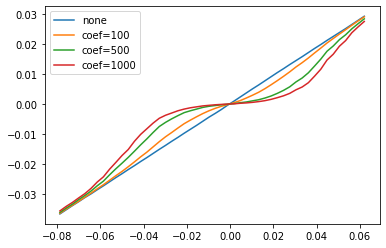

In [11]:
plt.plot(trade_signals, opt_predictions_none, label='none')
plt.plot(trade_signals, opt_predictions, label='coef=100')
plt.plot(trade_signals, opt_predictions_500, label='coef=500')
plt.plot(trade_signals, opt_predictions_1000, label='coef=1000')
plt.legend()
plt.show()

W przypadku gdy część kwadratowa funkcji straty jest wyłączona z równania (pozostaje tylko moduł różnicy wartości) funkcja straty przyjmuje kształt regresji liniowej. W zależności od wartości współczynnika istotności części kwadratowej kształt funkcji straty przy wartościach bliskich zeru odwzorowuje większą istotność tych wartości - im większy współczynnik, tym wartości bardziej odstają od ich odpowiednika gdzie współczynnik wynosi zero. Umożliwia to lepsze odwzorowanie funkcji straty.